<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_30_PRAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 30회 ADP 복원

# 기계학습 (60점)

## 데이터 설명
- 데이터 출처 : 캐글어딘가.. 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p1.csv
- 데이터 설명 : 혈압 데이터 DBP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p1.csv')
df.head(3)

,Age,Gender,BMI,DBP,FPG,Chol,Tri,HDL,LDL,ALT,CCR,FFPG
0,26,1,20.1,81,5.8,4.36,0.86,0.90,2.43,12.0,63.8,5.40
1,40,1,17.7,54,4.6,3.70,1.02,1.50,2.04,9.2,70.3,4.10
2,40,2,19.7,53,5.3,5.87,1.29,1.75,3.37,10.1,61.1,4.85


#### 1-1  EDA를 시행하라

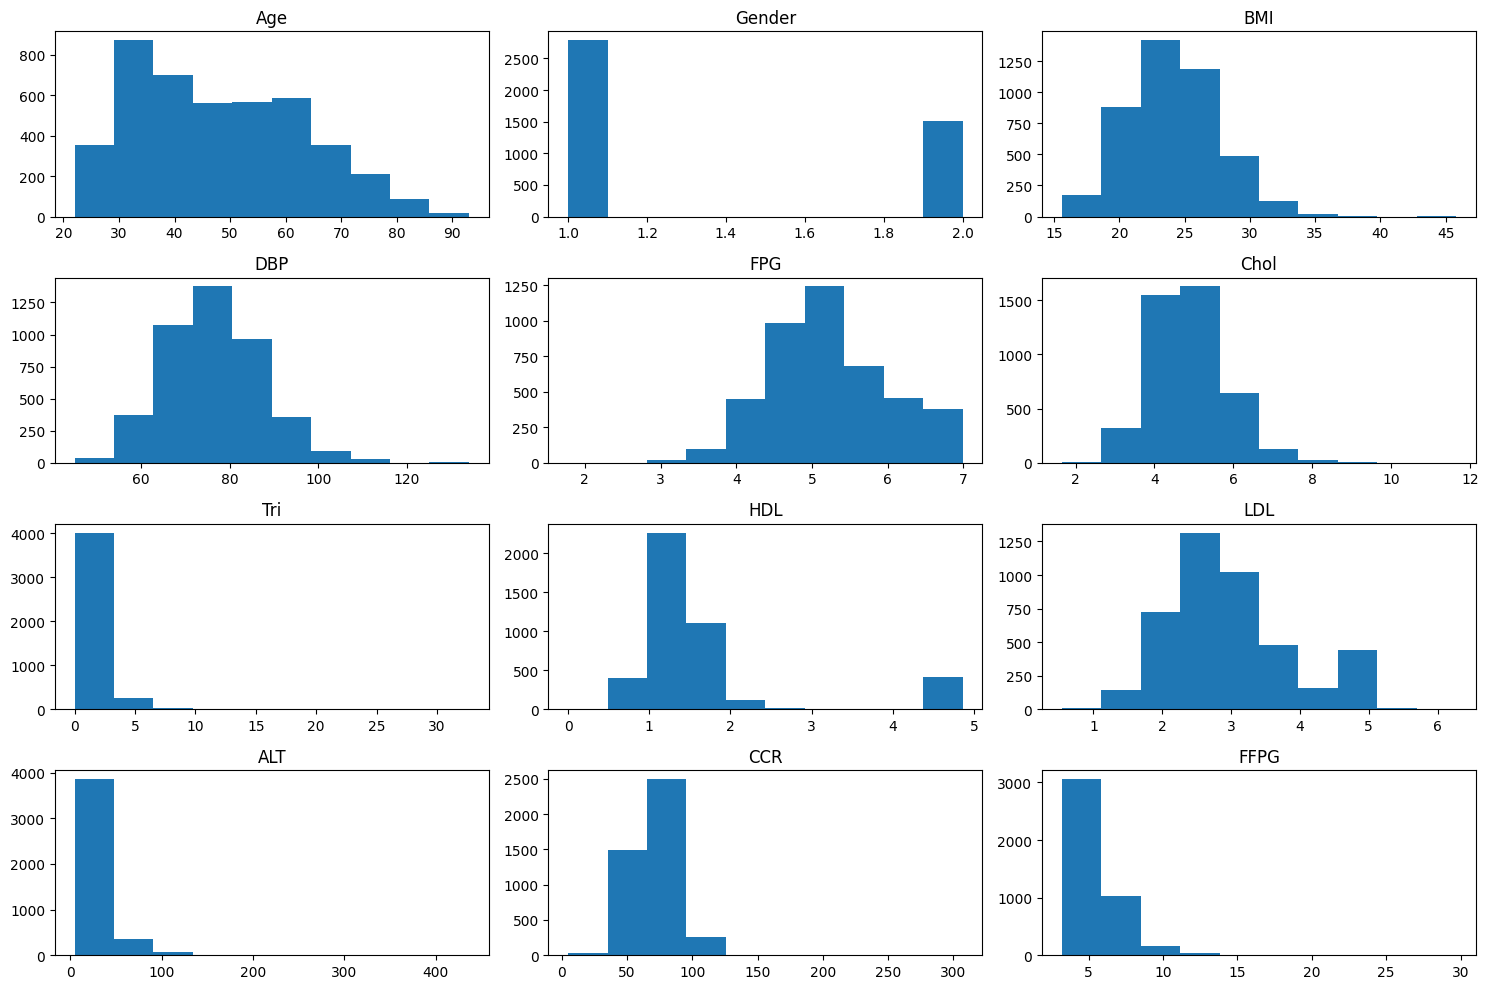

Age       0
Gender    0
BMI       0
DBP       0
FPG       0
Chol      1
Tri       0
HDL       0
LDL       0
ALT       0
CCR       0
FFPG      0
dtype: int64


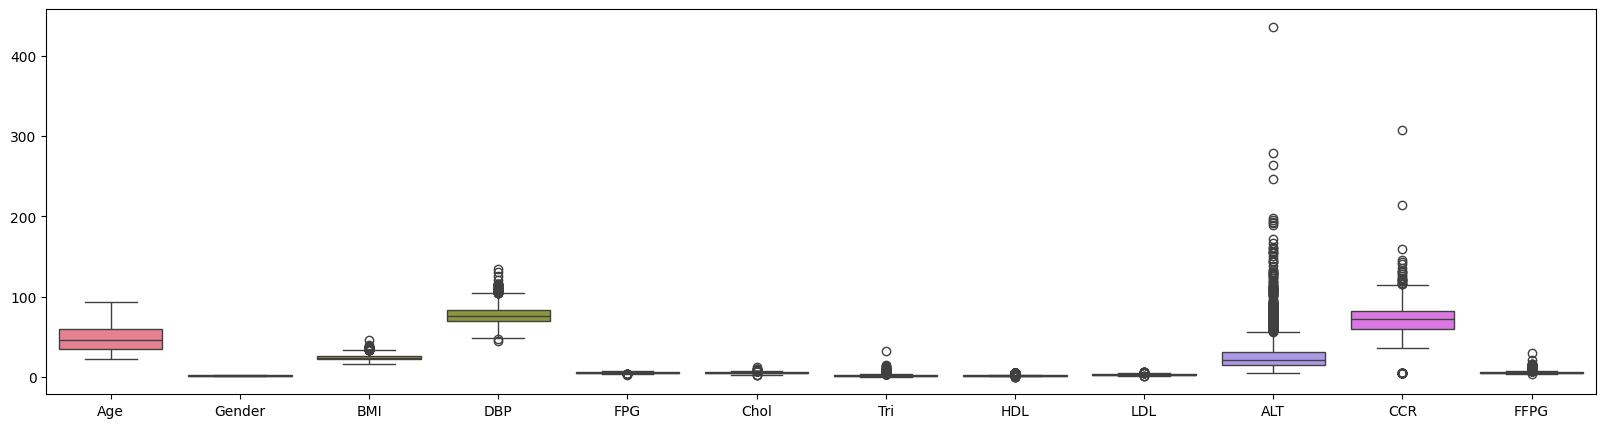

<Axes: >

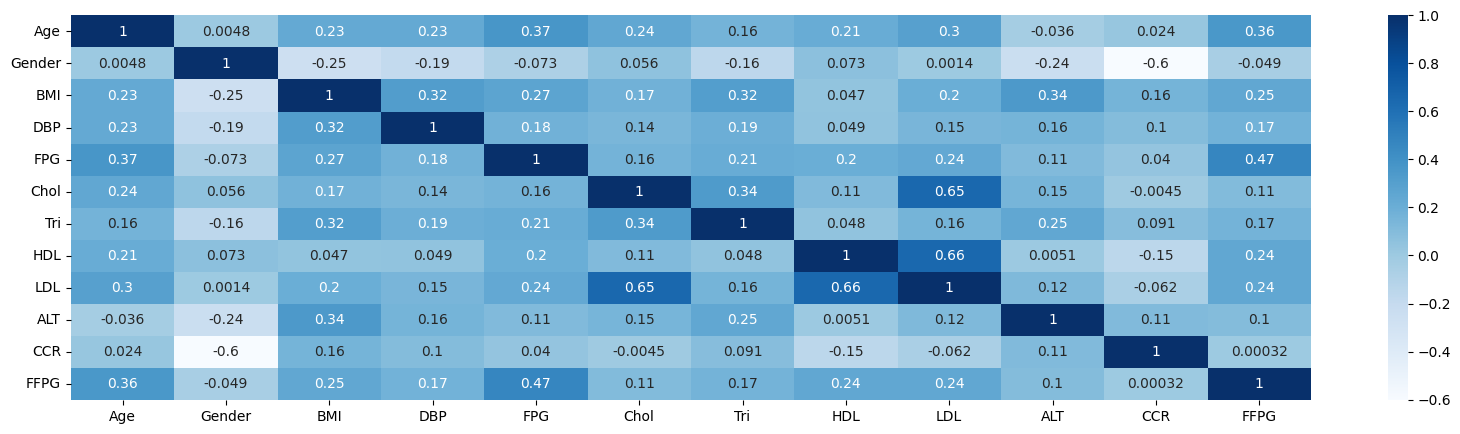

In [3]:
## 1. 분포도 시각화
fig, axes = plt.subplots(4,3, figsize = (15, 10))

for axes, col in zip(axes.flatten() , df.columns)  :
  axes.hist(df[col])
  axes.set_title(col)

plt.tight_layout()
plt.show()

## 2. NA 결측
print(df.isna().sum())
# 결측제거
df = df.dropna()

## 3. 이상치 확인
plt.figure(figsize = (20, 5))
sns.boxplot(data = df)
plt.show()

## 4. 상관분석
plt.figure(figsize = (20, 5))
cor_df = df.corr(method = 'pearson')
sns.heatmap(cor_df, annot = True, cmap = 'Blues')

#### 1-2 데이터 전처리가 필요하다면 수행하고 이유를 작성하라

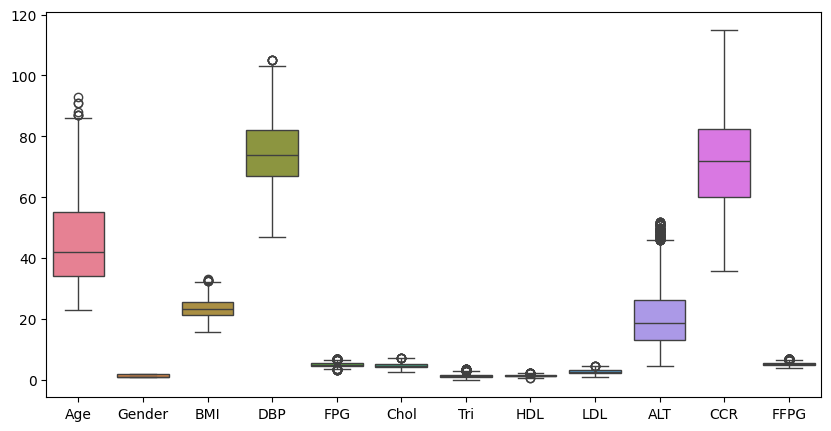

In [4]:
# 1. 이상치 제거
# for문 안에서 copy()하지 않기 - 덮어써짐
out_df = df.copy()

for col in out_df.columns :
  q1 = out_df[col].quantile(0.25)
  q3 = out_df[col].quantile(0.75)
  iqr = q3 - q1

  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr

  out_df = out_df[(out_df[col] >= lower) & (out_df[col] <= upper)]

plt.figure(figsize=(10, 5))
sns.boxplot(data=out_df)

# 2. Scaling
ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(out_df) , columns = out_df.columns)

#### 1-3 train test set을 DBP컬럼 기준으로 7:3 비율로 나누고 잘 나뉘었는지 통계적으로 나타내라

In [5]:
from scipy.stats import ttest_ind

train, test = train_test_split(scaled_df, test_size = 0.3 , random_state = 1234)

# 귀무가설 : 두 그룹의 평균은 같다
# 대립가설 : 두 그룹의 평균은 다르다.
stat, p_val = ttest_ind(train['DBP'], test['DBP'])

if p_val < 0.05 :
  print('귀무가설기각-평균은 다르다')
else :
  print('귀무가설채택-평균은 같다')

귀무가설채택-평균은 같다


#### 2-1 독립변수의 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오

In [6]:
# 차원 축소의 필요 근거 - 이상치를 제거한 원본을 사용
X = out_df.drop(columns = 'DBP', axis =1)

from statsmodels.stats.outliers_influence import variance_inflation_factor
# 1. VIF
vif = pd.DataFrame()
vif['cols'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif.T)

# 2. 상관분석
cor_df = out_df.corr().unstack().reset_index(name = 'cor')
cor_df[(cor_df['cor'] >= 0.7) & (cor_df['cor'] != 1)]


,0,1,2,3,4,5,6,7,8,9,10
cols,Age,Gender,BMI,FPG,Chol,Tri,HDL,LDL,ALT,CCR,FFPG
VIF,14.48733,15.295251,72.259641,83.797682,233.873839,7.781505,34.801354,110.311657,7.557622,34.160556,114.437313


,level_0,level_1,cor
68,Chol,LDL,0.887916
101,LDL,Chol,0.887916


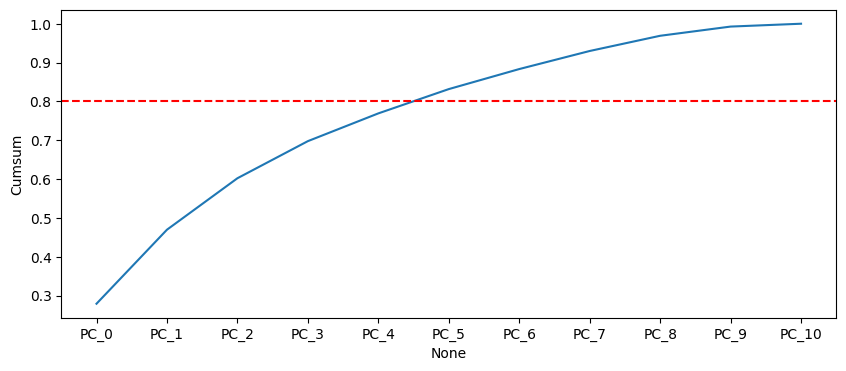

In [7]:
from sklearn.decomposition import PCA

pca_x = scaled_df.drop(columns = 'DBP', axis =1)

pca = PCA()
pca.fit(pca_x)
pca_df = pd.DataFrame({
    'Ratio' : pca.explained_variance_ratio_ ,
    'Cumsum' : pca.explained_variance_ratio_.cumsum()
})
pca_df.index = ['PC_' + str(x) for x in pca_df.index]

plt.figure(figsize = (10, 4))
sns.lineplot(x = pca_df.index , y = pca_df['Cumsum'])
plt.axhline(0.8, color = 'red', linestyle = '--')
plt.show()


In [8]:
## PCA-5로 축소
pca5 = PCA(n_components = 5)
p_x = pd.DataFrame(pca5.fit_transform(pca_x)  , columns = ['PC_' + str(x+1) for  x in range(0,5)])



## 2-2 2-1 작업 후 데이터가 회귀분석의 기본가정 따르는지 설명

In [9]:
# p_x
y = scaled_df['DBP']

import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, probplot

# 회귀식
add_x = sm.add_constant(p_x)
model = sm.OLS(y, add_x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    DBP   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     98.60
Date:                Fri, 18 Jul 2025   Prob (F-statistic):           2.12e-96
Time:                        04:37:37   Log-Likelihood:                -3995.7
No. Observations:                2977   AIC:                             8003.
Df Residuals:                    2971   BIC:                             8039.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.137e-16      0.017   3.61e-14      1.0

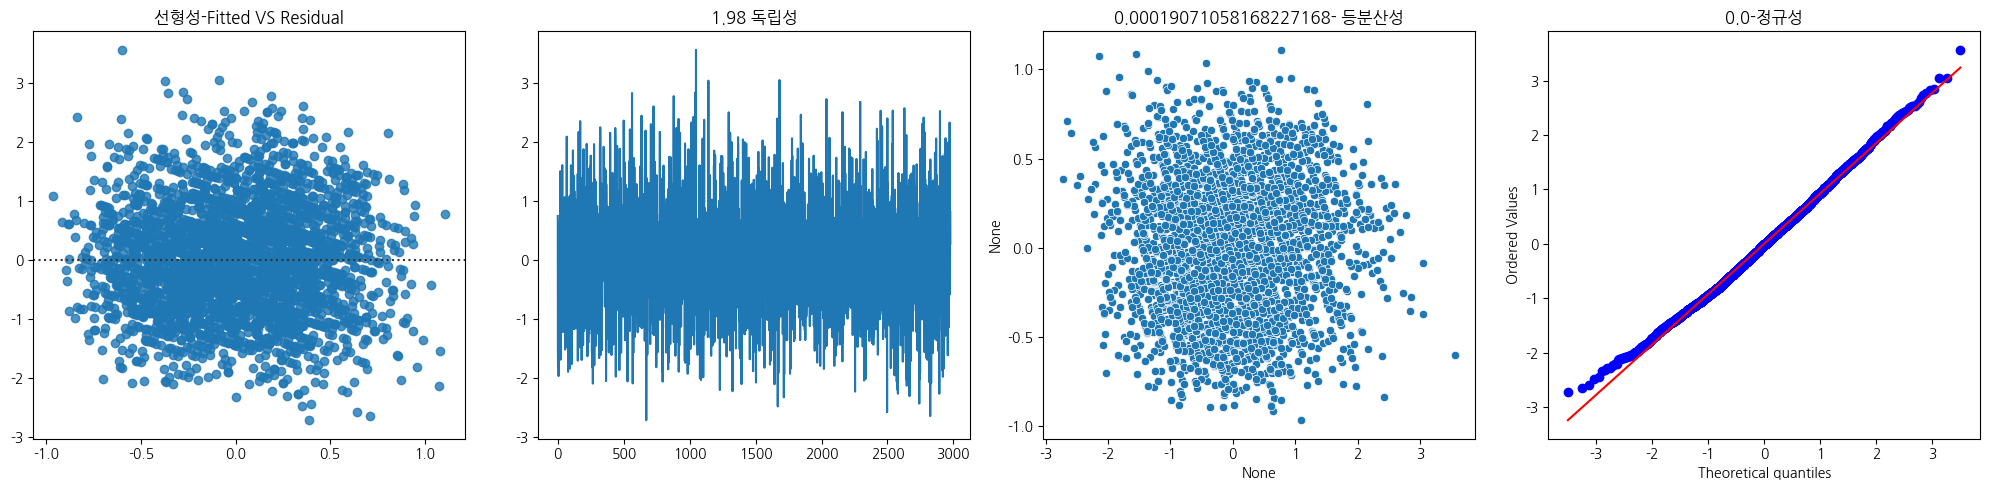

In [10]:

import matplotlib.pyplot as plt
plt.rcParams["font.family"]="NanumGothic"

# 3. 마이너스(-) 깨짐 방지 (필수)
plt.rc('axes', unicode_minus=False)
# 잔차 & 예측값
resid = model.resid
fitted = model.fittedvalues


fig, axes = plt.subplots(1,4, figsize = (20,5))
sns.residplot(x = fitted, y = resid, ax = axes[0])
axes[0].set_title('선형성-Fitted VS Residual')

# 2.독립
dw = durbin_watson(resid)
axes[1].plot(resid.values)
axes[1].set_title(f'{round(dw,2)} 독립성')

# 3.등분 : 잔차 VS 예측값 산점도
bp = het_breuschpagan(resid, model.model.exog)
pval = bp[1]
sns.scatterplot(x = resid, y = fitted, ax = axes[2])
axes[2].set_title(f'{pval}- 등분산성')

# 4. 정규성
pval = shapiro(resid).pvalue
probplot(resid, dist = 'norm', plot = axes[3])
axes[3].set_title(f'{round(pval,2)}-정규성')

plt.tight_layout()
plt.show()

## 3-1 회귀분석 알고리즘 3개를 선택하고 선정이유와 장단점 비교

In [11]:
print('''
[SVM (Support Vector Machine)]
 > 특징
 - SVM은 분류(classification)와 회귀(regression) 모두에 사용될 수 있다.
 - SVM은 데이터의 비선형 관계를 잘 모델링할 수 있도록 커널 기법을 사용할 수 있다.
 - 주로 선형 커널, 다항식 커널, 또는 가우시안 RBF 커널을 사용한다.
 - 최대 마진을 활용하여 결정 경계를 찾으며, 이로 인해 일반화 성능이 뛰어나다.

 > 장점 :
 - SVM은 선형 및 비선형 분류 문제에서 우수한 성능을 보이며,
   이상치(outlier)에 대한 강한 저항력을 가진다.
 - 다양한 커널 함수를 사용하여 다양한 데이터 유형에 대응할 수 있다.
 - SVM은 최대 마진을 추구하므로 일반화 성능이 우수하다.

 > 단점
 - SVM은 데이터의 스케일에 민감하므로 데이터 전처리가 중요하다.
 - 대용량 데이터셋에서는 계산 비용이 높을 수 있으며, 학습 시간이 오래 걸릴 수 있다.


[XGBoost (eXtreme Gradient Boosting)]
 > 특징
 - XGBoost는 트리 기반의 앙상블 학습 모델로, 그라디언트 부스팅(Gradient Boosting)을 기반으로 하며,
 과적합을 줄이기 위한 정규화와 가지치기 기능을 포함하고 있다.
 - 속도와 성능 면에서 우수하며, 다양한 분류 및 회귀 문제에 적용할 수 있다.
 - 특징 중요도 (변수 중요도)를 계산하여 변수 선택과 모델 해석에 용이하다.

 > 장점
 - XGBoost는 많은 데이터 경진 대회에서 우승을 차지하며, 다양한 데이터 유형에서 뛰어난 성능을 보인다.
 - 회귀, 분류, 랭킹, 예측 문제에 대한 다양한 손실 함수를 제공한다.
 - 정규화와 가지치기 기능을 통해 과적합을 줄일 수 있다.

 > 단점
 - 적절한 하이퍼파라미터를 선택하고 튜닝하는데 시간과 노력이 필요하다.
 - 메모리 요구량이 크고, 대용량 데이터에 대한 학습 및 예측 시간이 오래 걸릴 수 있다.


[RandomForest]
 > 특징
 - RandomForest는 의사결정 트리(Decision Tree)를 기반으로 하는 앙상블 학습 모델이다.
 - 여러 개의 의사결정 트리를 생성하고
   각 트리의 예측 결과를 결합하여 안정적이고 강력한 예측을 제공한다.
 - 과적합을 줄이기 위한 부트스트랩 샘플링과 무작위 특성 선택을 사용한다.

 > 장점
 - RandomForest는 과적합을 피하면서 좋은 예측 성능을 제공할 수 있다.
 - 특징 중요도 (변수 중요도) 를 평가하고 모델 해석에 용이하다.
 - 분류 및 회귀 문제 등 다양한 데이터에 널리 사용가능하다.

 > 단점
 - 트리의 개수가 많을수록 모델이 복잡해져 과적합 가능성이 높아질 수 있다.
   (학습데이터셋에 과대적합) 하이퍼파라미터를 조절하여 이를 방지하려는 노력을 해야한다.
 - RandomForest는 다수의 트리를 결합하여 예측을 수행하므로 개별 트리 해석이 어렵다.
''')



[SVM (Support Vector Machine)]
 > 특징
 - SVM은 분류(classification)와 회귀(regression) 모두에 사용될 수 있다.
 - SVM은 데이터의 비선형 관계를 잘 모델링할 수 있도록 커널 기법을 사용할 수 있다.
 - 주로 선형 커널, 다항식 커널, 또는 가우시안 RBF 커널을 사용한다.
 - 최대 마진을 활용하여 결정 경계를 찾으며, 이로 인해 일반화 성능이 뛰어나다.

 > 장점 :
 - SVM은 선형 및 비선형 분류 문제에서 우수한 성능을 보이며,
   이상치(outlier)에 대한 강한 저항력을 가진다.
 - 다양한 커널 함수를 사용하여 다양한 데이터 유형에 대응할 수 있다.
 - SVM은 최대 마진을 추구하므로 일반화 성능이 우수하다.

 > 단점
 - SVM은 데이터의 스케일에 민감하므로 데이터 전처리가 중요하다.
 - 대용량 데이터셋에서는 계산 비용이 높을 수 있으며, 학습 시간이 오래 걸릴 수 있다.


[XGBoost (eXtreme Gradient Boosting)]
 > 특징
 - XGBoost는 트리 기반의 앙상블 학습 모델로, 그라디언트 부스팅(Gradient Boosting)을 기반으로 하며,
 과적합을 줄이기 위한 정규화와 가지치기 기능을 포함하고 있다.
 - 속도와 성능 면에서 우수하며, 다양한 분류 및 회귀 문제에 적용할 수 있다.
 - 특징 중요도 (변수 중요도)를 계산하여 변수 선택과 모델 해석에 용이하다.

 > 장점
 - XGBoost는 많은 데이터 경진 대회에서 우승을 차지하며, 다양한 데이터 유형에서 뛰어난 성능을 보인다.
 - 회귀, 분류, 랭킹, 예측 문제에 대한 다양한 손실 함수를 제공한다.
 - 정규화와 가지치기 기능을 통해 과적합을 줄일 수 있다.

 > 단점
 - 적절한 하이퍼파라미터를 선택하고 튜닝하는데 시간과 노력이 필요하다.
 - 메모리 요구량이 크고, 대용량 데이터에 대한 학습 및 예측 시간이 오래 걸릴 수 있다.


[RandomForest]
 > 특징

## 3-2. 1-3에서 구분한 데이터를 기준으로 3개의 회귀 분석 모델링을 진행하고 평가지표 rmse로 가장 최적화된 알고리즘 선정

In [12]:
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

x_train = train.drop('DBP', axis = 1)
y_train = train['DBP']

x_test = test.drop('DBP', axis = 1)
y_test = test['DBP']

def eval(name, model) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)

  # RMSE(Root Mean Squared Error, 평균제곱근오차)는 회귀 분석에서 예측값과 실제값의 차이
  RMSE = np.sqrt(mean_squared_error(y_test, pred))
  return name, RMSE

res = []
for name, model in [['SVR', SVR()], ['RF', RandomForestRegressor()] ,['xgb', XGBRegressor()]] :
  name, RMSE = eval(name, model)
  res.append({
      'Model Name' : name,
      'RSME' : RMSE
  })

pd.DataFrame(res)
# RSME가 낮을 수록 좋은 모델

,Model Name,RSME
0,SVR,0.946830
1,RF,0.950846
2,xgb,1.008495


## 3-3 3-2에서 가장 성능 좋은 알고리즘을 이용하여 K-Fold 교차검증을 수행하시오.

In [13]:
from sklearn.model_selection import KFold, cross_val_score
y = out_df['DBP']
scaled_x = pd.DataFrame(StandardScaler().fit_transform(out_df.drop('DBP', axis = 1)) , columns = out_df.drop('DBP', axis = 1).columns)

# K-Fold 지정
k = KFold(n_splits= 5, shuffle= True, random_state = 45)

# 평가-neg_mean_squared_error
score = cross_val_score(RandomForestRegressor() , scaled_x, y, scoring = 'neg_mean_squared_error',cv = k)

# MSE
mse = -score

# RMSE
rmse = np.sqrt(mse)
print(np.mean(rmse)) #평균적으로 예측-실제의 차이가 10

print(pd.DataFrame({
    'Fold' : range(1, len(mse) + 1) ,
    'MSE' : mse
}))


9.52405818972672
   Fold        MSE
0     1  98.042923
1     2  87.958240
2     3  84.254582
3     4  88.487519
4     5  95.144669


## 데이터 설명
- 데이터 출처 : https://taas.koroad.or.kr/api/selectOpenApi.do 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p2_v2.csv
- 데이터 설명 : 자전거사고 다발지역 개별사고 정보
1) 대상사고 : 해당 1년간 발생한 가해 또는 피해차종이 자전거인 교통사고
2) 다발지역 선정조건 : 반경 300m 내 대상사고 4건이상 발생지역
3) 종속 변수 : 피해자신체상해정도

In [34]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p2.csv',encoding='cp949')
df.head(3)


,사고내용,가해자성별,가해자연령,가해자차종,피해자신체상해정도,사고유형,기상상태,사망자수,발생시각
0,경상,여,75세,자전거,경상,차대차 - 기타,맑음,0,2018-04-03 15시
1,중상,여,26세,자전거,중상,차대차 - 측면충돌,맑음,0,2018-04-21 13시
2,중상,남,34세,자전거,중상,차대차 - 기타,맑음,0,2018-05-01 08시


In [35]:
df = df.dropna()

#### 4-1 발생시각을 통해 평일인지 주말인지를 구분하는  '주말여부'  범주형 변수 추가하고 데이터 분포를 확인하라. (월 ~ 금은 평일, 토요일과 일요일을 주말)

In [36]:
df['발생시각'] = pd.to_datetime(df['발생시각'] , format = '%Y-%m-%d %H시' )
df['주말여부'] = df['발생시각'].dt.dayofweek.apply(lambda x : 1 if x in [5,6] else 0).astype(str)


#### 4-2 '피해자신체상해정도' 에 따라 각 독립변수들이 유의한지 통계적 검정하라.

In [37]:
# 전처리 우선
df['가해자연령'] = df['가해자연령'].str.split('세').str[0].astype(str)
df['사망자수'] = df['사망자수'].astype(str)

In [38]:
from scipy.stats import chi2_contingency, ttest_ind

cols = ['사고내용', '가해자성별', '가해자연령', '가해자차종', '사고유형', '기상상태', '사망자수', '주말여부']

# 피해자신체상해정도- 경상, 중상
res = []
for col in cols :
  if df[col].dtype == 'object' :
    cross = pd.crosstab(df[col], df['피해자신체상해정도'])
    stat, p_val, _, _  = chi2_contingency(cross)
    if p_val < 0.05 :
      decision = '유의하다'
    else :
      decision = '유의하지않다'

  else :
    g1 = df[df['피해자신체상해정도'] == '경상'][col]
    g2 = df[df['피해자신체상해정도'] == '중상'][col]

    stat, p_val = ttest_ind(g1, g2)
    if p_val < 0.05 :
      decision = '유의하다'
    else :
      decision = '유의하지않다'
  res.append([col, p_val, decision])

pd.DataFrame(res, columns = ['column','p_value','decision'])

,column,p_value,decision
0,사고내용,0.000000,유의하다
1,가해자성별,0.329743,유의하지않다
2,가해자연령,0.698280,유의하지않다
3,가해자차종,0.028998,유의하다
4,사고유형,0.021401,유의하다
5,기상상태,0.076903,유의하지않다
6,사망자수,0.853132,유의하지않다
7,주말여부,0.111578,유의하지않다


#### 4-3 4-2 에서 유의한 변수들만을 가지고 '피해자신체상해정도'를 기준으로 SMOTE 오버샘플링을 수행하고 샘플링 데이터와 기존데이터를 합친 전체 데이터에 대해 범주형변수는 변수별 빈도를 나타내고 연속형이면 평균을 나타내시오

In [39]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler # Import StandardScaler

r_df = df[['사고내용','가해자차종','사고유형', '피해자신체상해정도']]

La = LabelEncoder()
for col in r_df.columns :
  r_df[col] =  La.fit_transform(r_df[col])

y = r_df['피해자신체상해정도']
X = r_df.drop(columns = ['피해자신체상해정도'], axis = 1)

sm = SMOTE()
sm_x, sm_y = sm.fit_resample(X, y) # Apply SMOTE

sum_x = pd.concat([X, sm_x], axis = 0)
sum_y = pd.concat([y, sm_y], axis = 0)

for col in sum_x.columns :
  print(sum_x[col].value_counts())



사고내용
0    2844
1    2438
Name: count, dtype: int64
가해자차종
0    3779
1     852
2     651
Name: count, dtype: int64
사고유형
3    2963
1    1820
0     282
2     217
Name: count, dtype: int64


#### 4-4 4-3 데이터를 가지고 '피해자신체상해정도' 을 종속변수로 하여 로지스틱회귀분석, XGB 분류 분류 모델을 만들고 성능 비교를 하고 영향력 있는 변수를 확인하라

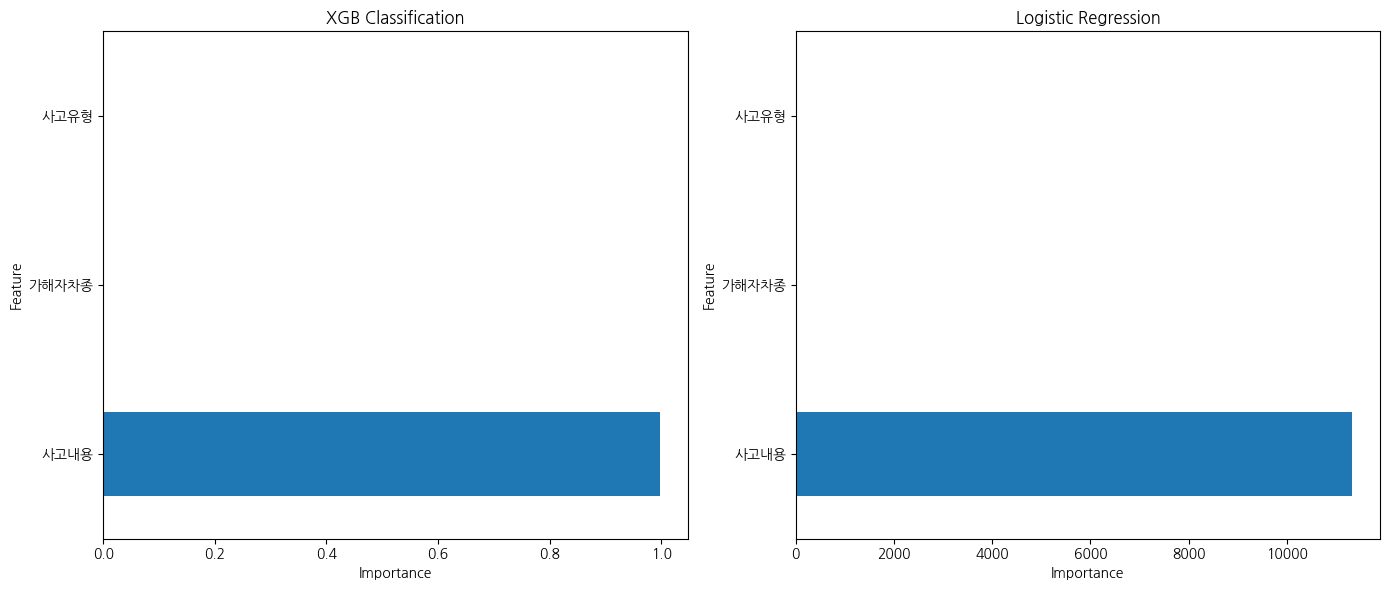

In [47]:
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBRFClassifier
from sklearn.linear_model import LogisticRegression

def eval(name, model) :
  x_train, x_test, y_train, y_test = train_test_split(sum_x, sum_y , test_size = 0.3, random_state = 1234)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)

  acc = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  return name, acc, f1

res = []
model_lst = []
for name, model in [['xgb', XGBRFClassifier()], ['LG' , LogisticRegression()]] :
  name, acc, f1 = eval(name, model)
  model_lst.append([name, model])
  res.append({
      'Model Name' : name,
      'Accuracy' : acc,
      'F1' : f1
  })

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (name, model) in enumerate(model_lst):
    if name == 'xgb':
        importances = model.feature_importances_
        features = model.feature_names_in_
        imp = pd.Series(importances, index=features)
        title = 'XGB Classification'
    elif name == 'LG':
        importances = np.exp(model.coef_[0])
        features = model.feature_names_in_
        imp = pd.Series(importances, index=features)
        title = 'Logistic Regression'
    else:
        continue

    imp.plot(kind='barh', ax=axes[idx])
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Importance')
    axes[idx].set_ylabel('Feature')

plt.tight_layout()
plt.show()


# 통계 (40점)

## 5.
3개의 공장에서 생산한 제품을 3지역으로 가능한 조건에 맞게 최대로 배송한다.    
각 공장과 각 지역 사이의 1개 제품 배송 비용이 아래와 같을 때, 최소 배송 비용은 얼마인가?    
![img](https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p5.png)

In [51]:
!pip install pulp
import pulp

# 1.변수를 정의
a1 = pulp.LpVariable(name='a1', lowBound=0) # a공장 - 지역1
a2 = pulp.LpVariable(name='a2', lowBound=0) # a공장 - 지역2
a3 = pulp.LpVariable(name='a3', lowBound=0) # a공장 - 지역3
b1 = pulp.LpVariable(name='b1', lowBound=0) # b공장 - 지역1
b2 = pulp.LpVariable(name='b2', lowBound=0) # b공장 - 지역2
b3 = pulp.LpVariable(name='b3', lowBound=0) # b공장 - 지역3
c1 = pulp.LpVariable(name='c1', lowBound=0) # c공장 - 지역1
c2 = pulp.LpVariable(name='c2', lowBound=0) # c공장 - 지역2
c3 = pulp.LpVariable(name='c3', lowBound=0) # c공장 - 지역3

# 2. 문제정의
model = pulp.LpProblem(name='model', sense=pulp.LpMinimize) # 최소값 최적해탐색

# 3. 목적함수 정의
model.objective = (20 * a1) + (5 * a2) + (35 * a3) \
                + (15 * b1) + (2 * b2) + (20 * b3) \
                + (3 * c1) + (14 * c2) + (17 * c3)

#print(model.objective)

# 4. 제약조건 정의
constraints = [a1 + b1 + c1 == 80, # 지역1수요
               a2 + b2 + c2 == 50, # 지역2수요
               a3 + b3 + c3 == 60, # 지역3수요
               a1 + a2 + a3 <= 75, # 공장a공급
               b1 + b2 + b3 <= 55, # 공장b공급
               c1 + c2 + c3 <= 60] # 공장c공급

# 5. 목적함수에 제약조건 설정
for i, c in enumerate(constraints) :
    constraint_name = f"const_{i}"
    model.constraints[constraint_name] = c
#print(model.constraints)

# 6. 문제해결
model.solve()

# 7. 결과값 확인
print('''선형계획법으로 최소운송비용을 찾은 결과 각 변수의 결과는 다음과 같다.''')
for v in model.variables() :
    #print(v)
    #print(v.varValue)
    print(v, ' : ', v.varValue)

print('''
수식 : {}

최소비용으로 찾은 최적해결과를 문제 수식에 대입하여 결과를 도출한다.
최소배송비용 : {}
'''
.format(model.objective, 20*25 + 5*50 + 35*0 + 15*0 + 2*0 + 20*55 + 3*55 + 14*0 + 17*5))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 38.7 MB/s eta 0:00:00
선형계획법으로 최소운송비용을 찾은 결과 각 변수의 결과는 다음과 같다.
a1  :  25.0
a2  :  50.0
a3  :  0.0
b1  :  0.0
b2  :  0.0
b3  :  55.0
c1  :  55.0
c2  :  0.0
c3  :  5.0

수식 : 20*a1 + 5*a2 + 35*a3 + 15*b1 + 2*b2 + 20*b3 + 3*c1 + 14*c2 + 17*c3

최소비용으로 찾은 최적해결과를 문제 수식에 대입하여 결과를 도출한다.
최소배송비용 : 2100



## 데이터 설명
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p6.csv
- 데이터 설명 : 3개 연령층 (청년 장년 노년)의 A 헤드셋의 선호도 (1,2,3/ 범주형) 설문조사

#### 6.1 연령대별로 헤드셋 선호도에 차이가 있는지를 검정하기 위한 귀무가설과 연구가설을 설정해라.

In [56]:
from scipy.stats import chi2_contingency

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/30/p6.csv')
df.head()

print('''
귀무가설: 연령대별 선호도의 차이는 없다
대립가설: 연령대별 선호도의 차이는 있다.
''')



귀무가설: 연령대별 선호도의 차이는 없다
대립가설: 연령대별 선호도의 차이는 있다. 



#### 6.2 유의수준 하에서 통계 검정해라

In [57]:
cross = pd.crosstab(df['나이'], df['선호도'])
stat, p_val, _ , _ = chi2_contingency(cross)

print(f'유의확률 {p_val} > 0.05 보다 크기 때문에 귀무가설을 채택 연령대별 선호도의 유의미한 차이는 없다')

유의확률 0.9919538273457956 > 0.05 보다 크기 때문에 귀무가설을 채택 연령대별 선호도의 유의미한 차이는 없다


## 데이터 설명
아이를 6명 가진 가정이 5 가족이고, 아들/딸을 출생할 확률은 0.5이다.

#### 7.1 딸이 4명 이상인 가구가 3 가족 이상일 확률을 구하라. (소숫점 이하 4번째 자리에서 반올림)

In [58]:
from scipy.stats import binom
n = 6
p = 0.5

rv = binom(n, p)

# 한 가족에서 딸이 4명 이상일 확률
d_4 = 1 - rv.cdf(3)
print(round(d_4, 4))

# 5가족 중, 3가구 이상이 딸이 4명인 가족일 확률 > 3가구 이상일 확률
rv2 = binom(5, d_4)
family_3 = 1 - rv2.cdf(2)
print(family_3)



0.3438
0.2255459427833557



#### 7.2 5가족 중 몇 가족이 4명 이상 딸을 가질 것으로 기대할 수 있는가? (소숫점 이하 4번째 자리에서 반올림)

In [59]:
n = 6
p = 0.5

rv = binom(n, p)
d_4_more = 1 - rv.cdf(3)

# 5가족 중 기대되는 수 : n * p
print(5 * d_4_more)

1.71875


In [63]:
#10문제로 구성된 객관식 시험이 있다. 각 문제의 정답을 찍을 확률은 0.25이다.
#한 학생이 6문제 이상 맞출 확률을 구하라.
#이런 학생이 8명 있을 때, 2명 이상이 6문제 이상 맞출 확률을 구하라.

rv = binom(10, 0.25)

# 6문제 이상 맞출 확률
more_6 = 1 - rv.cdf(5)
print(f'한 학생이 6문제 이상 맞출 확률: {more_6:.5f}')

rv2 = binom(8,more_6)
print(f'8명 중 2명 이상 6문제 이상 맞출 확률: {1 - rv2.cdf(1):.5f}')

한 학생이 6문제 이상 맞출 확률: 0.01973
8명 중 2명 이상 6문제 이상 맞출 확률: 0.01007


In [66]:
#어떤 주사위를 7번 던질 때, '6'이 3번 이상 나올 확률을 구하라.
#이 실험을 6명이 동시에 진행할 때, 2명 이상이 '6'을 3번 이상 맞출 확률

rv = binom(7, 1/6)
more_3 = 1 - rv.cdf(2)
print(more_3)

rv2 = binom(6, more_3)
print(1 - rv2.cdf(1))

0.09577546296296302
0.10604926350878086


In [68]:
#어떤 회사에 7명의 사원이 있다.
#각 사원이 독립적으로 프로젝트를 성공시킬 확률은 0.3이다.
#이 중 적어도 한 명은 반드시 성공했다고 할 때,
#이 중 2명 이상이 성공할 확률을 구하라.
#그리고, 이런 회사가 5개 있을 때, 2개 이상의 회사에서 2명 이상이 성공할 확률을 구하라.

n , p = 7, 0.3

# 7명 중 2명 이상이 성공할 확률
more_2 = 1 - binom.cdf(1, n, p)
p0 = binom.pmf(0, n, p)

# 조건부 확률 : 2명 중 적어도 1명 이상
least_1 = more_2 / (1- p0)

# 5개가 있을 때 2개 이상
rv2 = binom(n, least_1)
ans = 1 - rv2.cdf(1)
print(ans)

0.9979490864678561


In [73]:
#어떤 회사에 7명의 사원이 있다.
#각 사원이 독립적으로 프로젝트를 성공시킬 확률은 0.3이다.
#이 중 적어도 한 명은 반드시 성공했다고 할 때,
#이 중 2명 이상이 성공할 확률을 구하라.
#그리고, 이런 회사가 5개 있을 때, 2개 이상의 회사에서 2명 이상이 성공할 확률

more2 = 1 - binom.cdf(1,7, 0.3)
p_0 = binom.pmf(0, 7, 0.3)

# 적어도 한명은 반드시 성공
rv2 = more2 / (1 -p_0)

# 5개 중 2개 이상
rv3 = binom(5, rv2)

ans = 1 - rv3.cdf(1)
print(ans)

0.9793863601567143


created by datamanim [web-link](https://www.datamanim.com)